# Regresión logística

Vamos a clasificar problemas con dos posibles estados (binario), o un número finito de "etiquetas" o "clases" (mùltiple).
Para eso usaremos un csv con datos de entrada a modo de ejemplo para clasificar si el usuario que visita un sitio web utiliza sistema operativo Windows, MacOS o Linux

Nuestra información de entrada son 4 características tomadas de una web que utiliza Google Analytics y son:

-Duración de la visita en Segundos
-Cantidad de Páginas Vistas durante la Sesión
-Cantidad de Acciones del usuario (click, scroll, uso de checkbox, sliders,etc)
-Suma del Valor de las acciones (cada acción lleva asociada una valoración de importancia)

Como la salida es discreta, asignaremos los siguientes valores a las etiquetas:

0 – Windows
1 – Macintosh
2 -Linux

La muestra es bastante pequeña, 170 sitios.

In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [2]:
df = pd.read_csv("data/usr.csv")
df.head()

,duracion,paginas,acciones,valor,clase
0,7.0,2,4,8,2
1,21.0,2,6,6,2
2,57.0,2,4,4,2
3,101.0,3,6,12,2
4,109.0,2,6,12,2


Llamamos al método df.describe() que nos dará algo de información estadística básica de nuestro set de datos. La Media, el desvío estándar, valores mínimo y máximo de cada característica.


In [5]:
df.describe()

,duracion,paginas,acciones,valor,clase
count,170.000000,170.000000,170.000000,170.000000,170.000000
mean,111.075729,2.041176,8.723529,32.676471,0.752941
std,202.453200,1.500911,9.136054,44.751993,0.841327
min,1.000000,1.000000,1.000000,1.000000,0.000000
25%,11.000000,1.000000,3.000000,8.000000,0.000000
50%,13.000000,2.000000,6.000000,20.000000,0.000000
75%,108.000000,2.000000,10.000000,36.000000,2.000000
max,898.000000,9.000000,63.000000,378.000000,2.000000


Luego analizaremos cuantos resultados tenemos de cada tipo usando la función groupby y vemos que tenemos 86 usuarios “Clase 0”, es decir Windows, 40 usuarios Mac y 44 de Linux.

In [7]:
print(df.groupby('clase').size())

clase
0    86
1    40
2    44
dtype: int64


Visualizamos los datos para comprender mejor las características de la información con la que trabajamos y su correlación

Primero visualizamos en formato de historial los cuatro Features de entrada con nombres “duración”, “páginas”,”acciones” y “valor” podemos ver gráficamente entre qué valores se comprenden sus mínimos y máximos y en qué intervalos concentran la mayor densidad de registros.

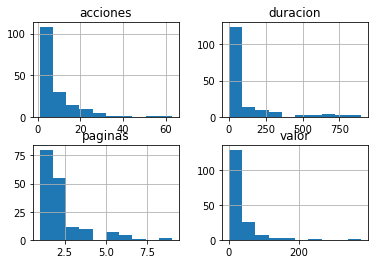

In [8]:
df.drop(['clase'],1).hist()
plt.show()

Y también podemos interrelacionar las entradas de a pares, para ver como se concentran linealmente las salidas de usuarios por colores: Sistema Operativo Windows en azul, Macintosh en verde y Linux en rojo.

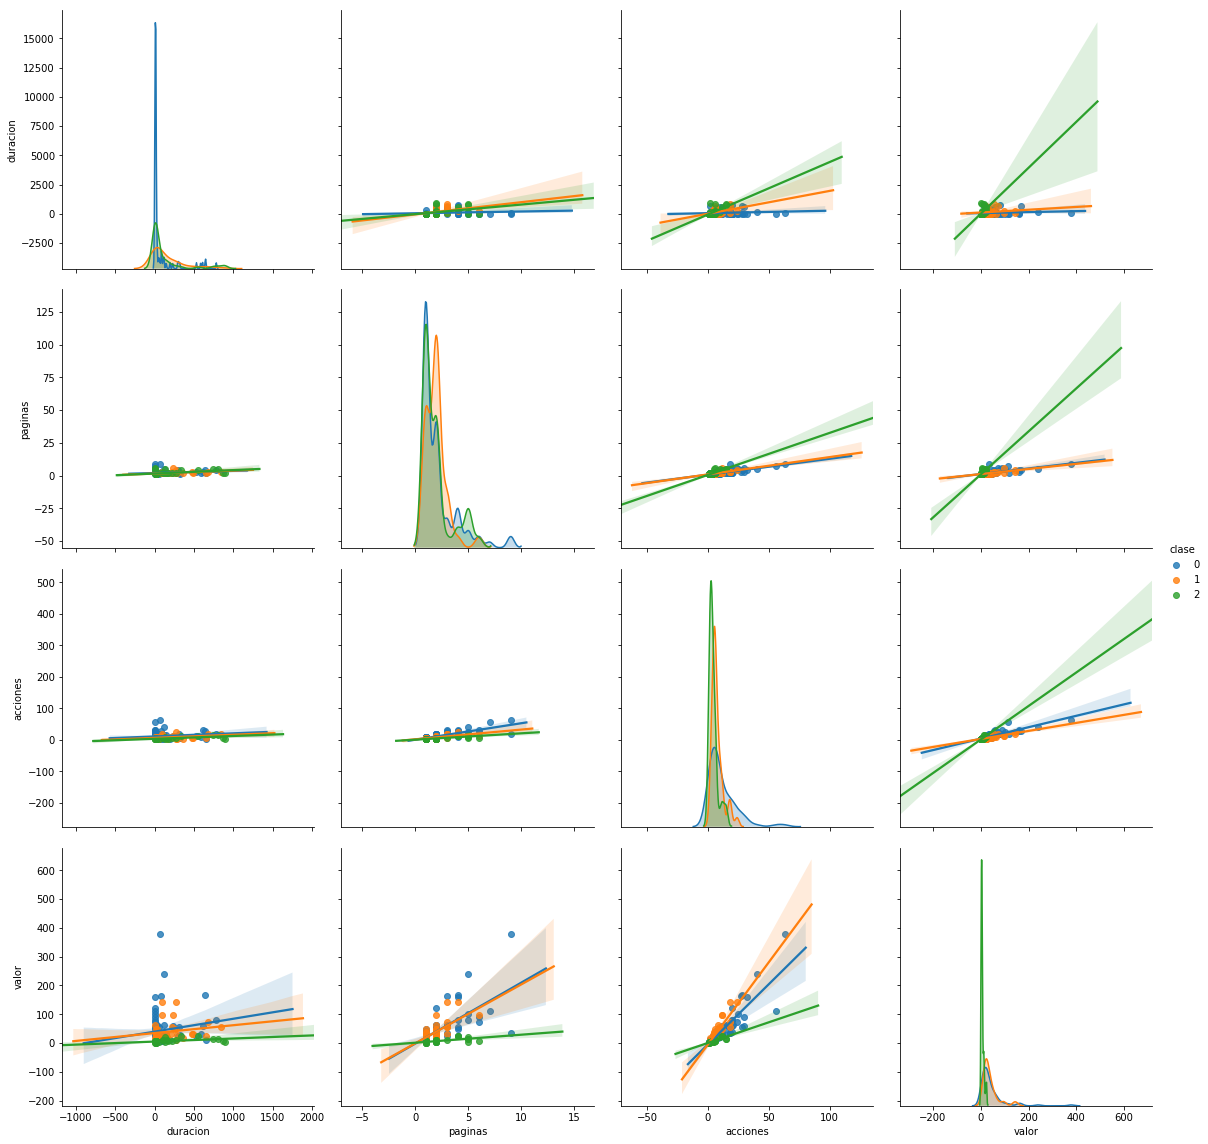

In [12]:
sns.pairplot(df.dropna(), hue='clase',size=4,vars=["duracion", "paginas","acciones","valor"],kind='reg')


## Creamos el Modelo de Regresión Logística

Ahora cargamos las variables de las 4 columnas de entrada en X excluyendo la columna “clase” con el método drop(). En cambio agregamos la columna “clase” en la variable y. Ejecutamos X.shape para comprobar la dimensión de nuestra matriz con datos de entrada de 170 registros por 4 columnas.

In [14]:
X = np.array(df.drop(['clase'],1))
y = np.array(df['clase'])
X.shape

(170L, 4L)

Y creamos nuestro modelo y hacemos que se ajuste (fit) a nuestro conjunto de entradas X y salidas ‘y’.


In [16]:
model = linear_model.LogisticRegression()
model.fit(X,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

Una vez compilado nuestro modelo, le hacemos clasificar todo nuestro conjunto de entradas X utilizando el método “predict(X)” y revisamos algunas de sus salidas y vemos que coincide con las salidas reales de nuestro archivo csv.

In [17]:
predictions = model.predict(X)
print(predictions)[0:5]

[2 2 2 2 2]


Y confirmamos cuan bueno fue nuestro modelo utilizando model.score() que nos devuelve la precisión media de las predicciones, en nuestro caso del 77%.

In [18]:
model.score(X,y)

0.7764705882352941

## Validación de nuestro modelo

Una buena práctica en Machine Learning es la de subdividir nuestro conjunto de datos de entrada en un set de entrenamiento y otro para validar el modelo (que no se utiliza durante el entrenamiento y por lo tanto la máquina desconoce). Esto evitará problemas en los que nuestro algoritmo pueda fallar por “sobregeneralizar” el conocimiento.

Para ello, subdividimos nuestros datos de entrada en forma aleatoria (mezclados) utilizando 80% de registros para entrenamiento y 20% para validar.

In [20]:
validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, y, test_size=validation_size, random_state=seed)

Volvemos a compilar nuestro modelo de Regresión Logística pero esta vez sólo con 80% de los datos de entrada y calculamos el nuevo scoring que ahora nos da 74%.

In [21]:
name='Logistic Regression'
kfold = model_selection.KFold(n_splits=10, random_state=seed)
cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
print(msg)

Logistic Regression: 0.743407 (0.115752)


Y ahora hacemos las predicciones -en realidad clasificación- utilizando nuestro “cross validation set”, es decir del subconjunto que habíamos apartado. En este caso vemos que los aciertos fueron del 85% pero hay que tener en cuenta que el tamaño de datos era pequeño.



In [22]:
predictions = model.predict(X_validation)
print(accuracy_score(Y_validation, predictions))


0.8529411764705882


Finalmente vemos en pantalla la “matriz de confusión” donde muestra cuantos resultados equivocados tuvo de cada clase (los que no están en la diagonal), por ejemplo predijo 3 usuarios que eran Mac como usuarios de Windows y predijo a 2 usuarios Linux que realmente eran de Windows.

In [23]:
print(confusion_matrix(Y_validation, predictions))

[[16  0  2]
 [ 3  3  0]
 [ 0  0 10]]


También podemos ver el reporte de clasificación con nuestro conjunto de Validación. En nuestro caso vemos que se utilizaron como “soporte” 18 registros windows, 6 de mac y 10 de Linux (total de 34 registros). Podemos ver la precisión con que se acertaron cada una de las clases y vemos que por ejemplo de Macintosh tuvo 3 aciertos y 3 fallos (0.5 recall). La valoración que de aqui nos conviene tener en cuenta es la de F1-score, que tiene en cuenta la precisión y recall. El promedio de F1 es de 84% lo cual no está nada mal.

In [24]:
print(classification_report(Y_validation, predictions))

              precision    recall  f1-score   support

           0       0.84      0.89      0.86        18
           1       1.00      0.50      0.67         6
           2       0.83      1.00      0.91        10

   micro avg       0.85      0.85      0.85        34
   macro avg       0.89      0.80      0.81        34
weighted avg       0.87      0.85      0.84        34



## Clasificación (o predicción) de nuevos valores

Como último ejercicio, vamos a inventar los datos de entrada de  navegación de un usuario ficticio que tiene estos valores:

Tiempo Duración: 10
Paginas visitadas: 3
Acciones al navegar: 5
Valoración: 9
Lo probamos en nuestro modelo y vemos que lo clasifica como un usuario tipo 2, es decir, de Linux.

In [26]:
X_new = pd.DataFrame({'duracion': [10], 'paginas': [3], 'acciones': [5], 'valor': [9]})
model.predict(X_new)

array([2], dtype=int64)